# Pneumonia Detection from X-ray Images

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Dependencies](#setup)
3. [Data Loading and Exploration](#data-loading)
4. [Feature Engineering](#feature-engineering)
5. [Model Development](#model-development)
6. [Model Evaluation](#model-evaluation)
7. [Model Interpretation](#model-interpretation)
8. [Conclusion](#conclusion)
9. [Next Steps](#next-steps)

## Introduction <a name="introduction"></a>
This notebook presents a comprehensive pipeline for detecting pneumonia from chest X-ray images using machine learning. The project follows a complete data science workflow from data exploration to model deployment.

## 1. Setup and Dependencies <a name="setup"></a>
First, let's import all necessary libraries and set up our environment.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter, ImageEnhance
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_curve, auc, roc_auc_score, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
import time
from tqdm import tqdm
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

os.makedirs('output/eda', exist_ok=True)
os.makedirs('output/features', exist_ok=True)
os.makedirs('output/models', exist_ok=True)
os.makedirs('output/confusion_matrices', exist_ok=True)

## 2. Set up paths

In [10]:
base_dir = os.path.join('..', 'pneumonia_dataset')
normal_dir = os.path.join(base_dir, 'Normal/images')
pneumonia_dir = os.path.join(base_dir, 'Pneumonia/images')

normal_images = [f for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
pneumonia_images = [f for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]

print(f'Number of Normal images: {len(normal_images)}')
print(f'Number of Pneumonia images: {len(pneumonia_images)}')
print(f'Total number of images: {len(normal_images) + len(pneumonia_images)}')

Number of Normal images: 4065
Number of Pneumonia images: 1345
Total number of images: 5410


## 3. Visualize class distribution

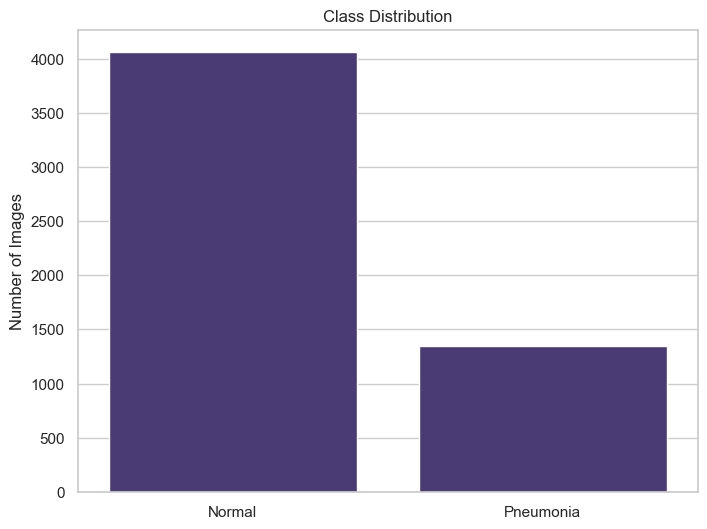

KeyboardInterrupt: 

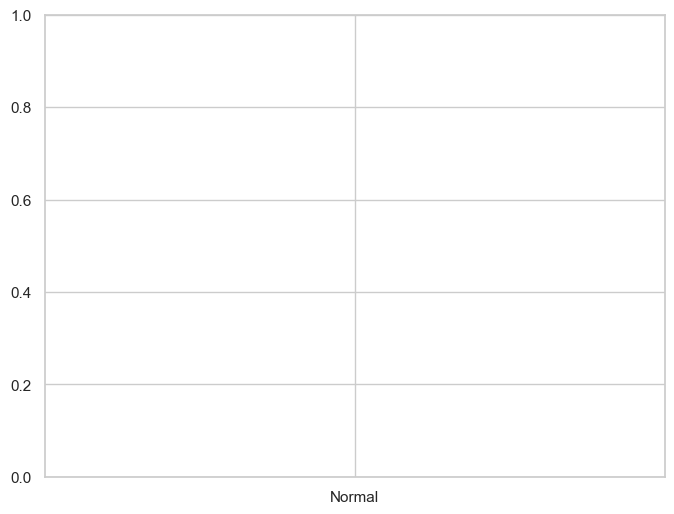

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Normal', 'Pneumonia'], y=[len(normal_images), len(pneumonia_images)])
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()

## 4. Data Loading and Exploration

Let's load the dataset and perform exploratory data analysis (EDA) to understand its characteristics.


Processing NORMAL images from: ..\pneumonia_dataset\Normal\images
Found 4065 NORMAL images

Processing PNEUMONIA images from: ..\pneumonia_dataset\Pneumonia\images
Found 4065 NORMAL images

Processing PNEUMONIA images from: ..\pneumonia_dataset\Pneumonia\images
Found 1345 PNEUMONIA images

Loaded 5410 images
Class distribution:
NORMAL       4065
PNEUMONIA    1345
Name: count, dtype: int64

First 5 rows of the dataset:
                                          image_path   label
0    ..\pneumonia_dataset\Normal\images\Normal-1.png  NORMAL
1   ..\pneumonia_dataset\Normal\images\Normal-10.png  NORMAL
2  ..\pneumonia_dataset\Normal\images\Normal-100.png  NORMAL
3  ..\pneumonia_dataset\Normal\images\Normal-1000...  NORMAL
4  ..\pneumonia_dataset\Normal\images\Normal-1001...  NORMAL

Dataset information:
Total images: 5410

Class distribution:
label
NORMAL       4065
PNEUMONIA    1345
Name: count, dtype: int64

Sample image: ..\pneumonia_dataset\Normal\images\Normal-1.png
Found 1345 PNEUMON

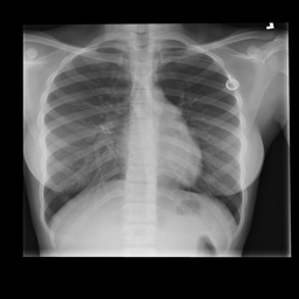

In [12]:
class PneumoniaDataLoader:
    def __init__(self, base_dir):
        """Initialize with the base directory containing 'Normal' and 'Pneumonia' folders."""
        self.base_dir = Path(base_dir)
        self.normal_dir = self.base_dir / 'Normal' / 'images'
        self.pneumonia_dir = self.base_dir / 'Pneumonia' / 'images'
        self.image_paths = []
        self.labels = []
        self.metadata = []
        self.load_data()
        
    def extract_metadata(self, img_path):
        """Extract basic metadata from an image."""
        try:
            with Image.open(img_path) as img:
                return {
                    'width': img.width,
                    'height': img.height,
                    'mode': img.mode,
                    'aspect_ratio': img.width / img.height if img.height > 0 else 0
                }
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None
        
    def load_data(self):
        """Load image paths, labels, and metadata from the specified directories."""
        
        if not self.normal_dir.exists():
            print(f"Warning: Directory not found: {self.normal_dir}")
            print(f"Looking for images in: {self.normal_dir.absolute()}")
            return
            
        if not self.pneumonia_dir.exists():
            print(f"Warning: Directory not found: {self.pneumonia_dir}")
            print(f"Looking for images in: {self.pneumonia_dir.absolute()}")
            return
            
        self._process_directory(self.normal_dir, 'NORMAL')
        
        self._process_directory(self.pneumonia_dir, 'PNEUMONIA')
        
        print(f"\nLoaded {len(self.image_paths)} images")
        if self.image_paths:
            print("Class distribution:")
            print(pd.Series(self.labels).value_counts())
        else:
            print("No images found. Please check the directory structure.")
            print(f"Current directory: {Path('.').absolute()}")
            print(f"Base directory: {self.base_dir.absolute()}")
        
    def _process_directory(self, directory, label):
        """Helper method to process a directory of images."""
        image_extensions = ('*.jpeg', '*.jpg', '*.png')
        print(f"\nProcessing {label} images from: {directory}")
        
        for ext in image_extensions:
            for img_path in directory.glob(f'*{ext}'):  
                self.image_paths.append(str(img_path))
                self.labels.append(label)
                
                meta = self.extract_metadata(img_path)
                if meta:
                    meta.update({'class': label})
                    self.metadata.append(meta)
                    
        print(f"Found {len([p for p in self.labels if p == label])} {label} images")
        
    def get_dataframe(self):
        """Return a DataFrame with image paths, labels, and metadata."""
        if not self.image_paths:
            raise ValueError("""
            No images were loaded. This could be because:
            1. The data directory structure is different than expected
            2. Image files are not in .jpeg, .jpg, or .png format
            3. The directory doesn't contain 'Normal/images' and 'Pneumonia/images' folders
            
            Current directory: {}
            Base directory: {}
            """.format(Path('.').absolute(), self.base_dir.absolute()))
            
        df = pd.DataFrame({
            'image_path': self.image_paths,
            'label': self.labels
        })
        
        if self.metadata:
            meta_df = pd.DataFrame(self.metadata)
            df = pd.concat([df, meta_df], axis=1)
            
        return df

try:
    data_loader = PneumoniaDataLoader('../pneumonia_dataset')
    df = data_loader.get_dataframe()
    print("\nFirst 5 rows of the dataset:")
    print(df[['image_path', 'label']].head())
    
    print("\nDataset information:")
    print(f"Total images: {len(df)}")
    print("\nClass distribution:")
    print(df['label'].value_counts())
    
    if not df.empty:
        sample = df.iloc[0]
        print(f"\nSample image: {sample['image_path']}")
        display(Image.open(sample['image_path']))
        
except Exception as e:
    print(f"Error: {e}")
    print("\nTroubleshooting steps:")
    print("1. Check if the directory exists:", Path('../pneumonia_dataset').absolute())
    print("2. Verify the directory contains 'Normal/images' and 'Pneumonia/images' folders")
    print("3. Make sure the images are in .jpeg, .jpg, or .png format")

## 5. Display Sample Images

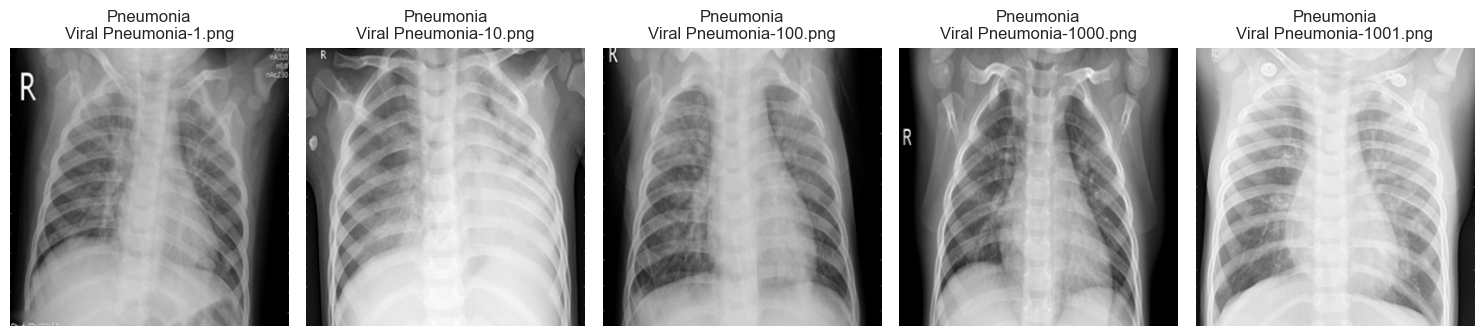

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import os

num_samples = 5
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(pneumonia_images[:num_samples]):
	img_path = os.path.join(pneumonia_dir, img_file)
	img = Image.open(img_path)
	plt.subplot(1, num_samples, i + 1)
	plt.imshow(img, cmap='gray')
	plt.title(f"Pneumonia\n{img_file}")
	plt.axis('off')
plt.tight_layout()
plt.show()

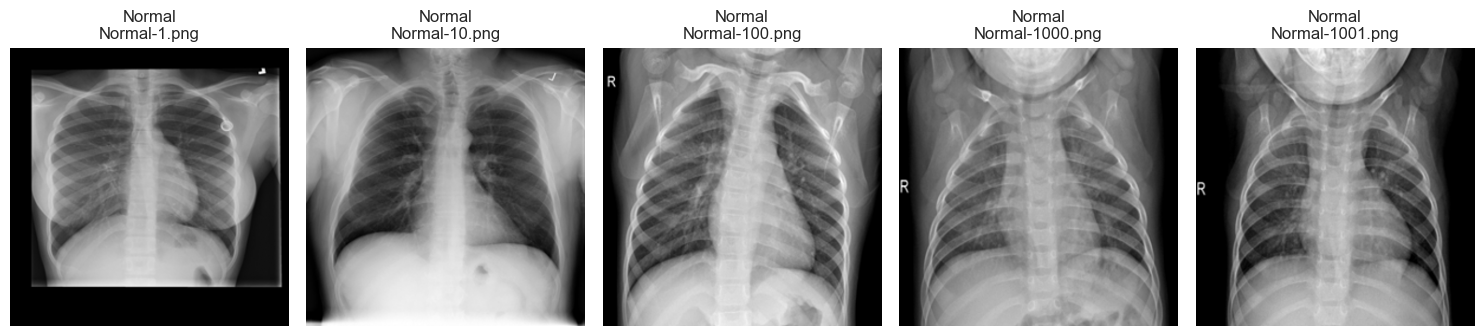

In [ ]:
num_samples = 5
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(normal_images[:num_samples]):
	img_path = os.path.join(normal_dir, img_file)
	img = Image.open(img_path)
	plt.subplot(1, num_samples, i + 1)
	plt.imshow(img, cmap='gray')
	plt.title(f"Normal\n{img_file}")
	plt.axis('off')
plt.tight_layout()
plt.show()

## 6. Analyze image sizes and formats

100%|██████████| 100/100 [00:00<00:00, 838.07it/s]


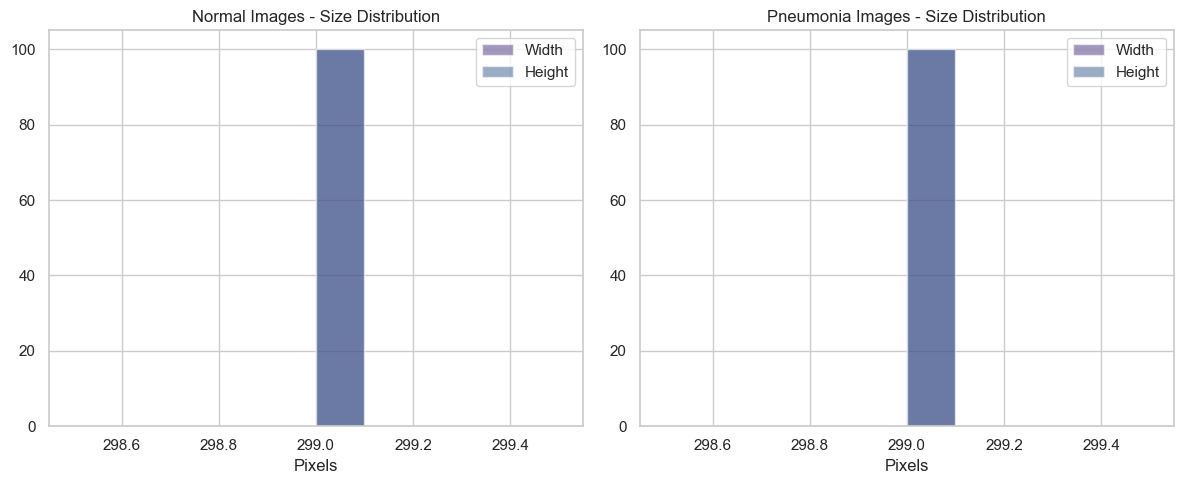

In [8]:
def get_image_stats(image_files, image_dir):
    sizes = []
    for img_file in tqdm(image_files[:100]): 
        img_path = os.path.join(image_dir, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)
    return sizes

# Get image statistics
normal_sizes = get_image_stats(normal_images, normal_dir)
pneumonia_sizes = get_image_stats(pneumonia_images, pneumonia_dir)

# Plot size distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([s[0] for s in normal_sizes], alpha=0.5, label='Width')
plt.hist([s[1] for s in normal_sizes], alpha=0.5, label='Height')
plt.title('Normal Images - Size Distribution')
plt.xlabel('Pixels')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([s[0] for s in pneumonia_sizes], alpha=0.5, label='Width')
plt.hist([s[1] for s in pneumonia_sizes], alpha=0.5, label='Height')
plt.title('Pneumonia Images - Size Distribution')
plt.xlabel('Pixels')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Feature Extraction

Extracting features for 100 images...


  0%|          | 0/100 [00:00<?, ?it/s]


Feature extraction complete.
X shape: (100, 52208)
y shape: (100,)

Visualizing features for: ..\pneumonia_dataset\Normal\images\Normal-3139.png
Feature visualization saved to output/feature_visualization/normal_Normal-3139.png.png
Feature visualization saved to output/feature_visualization/normal_Normal-3139.png.png


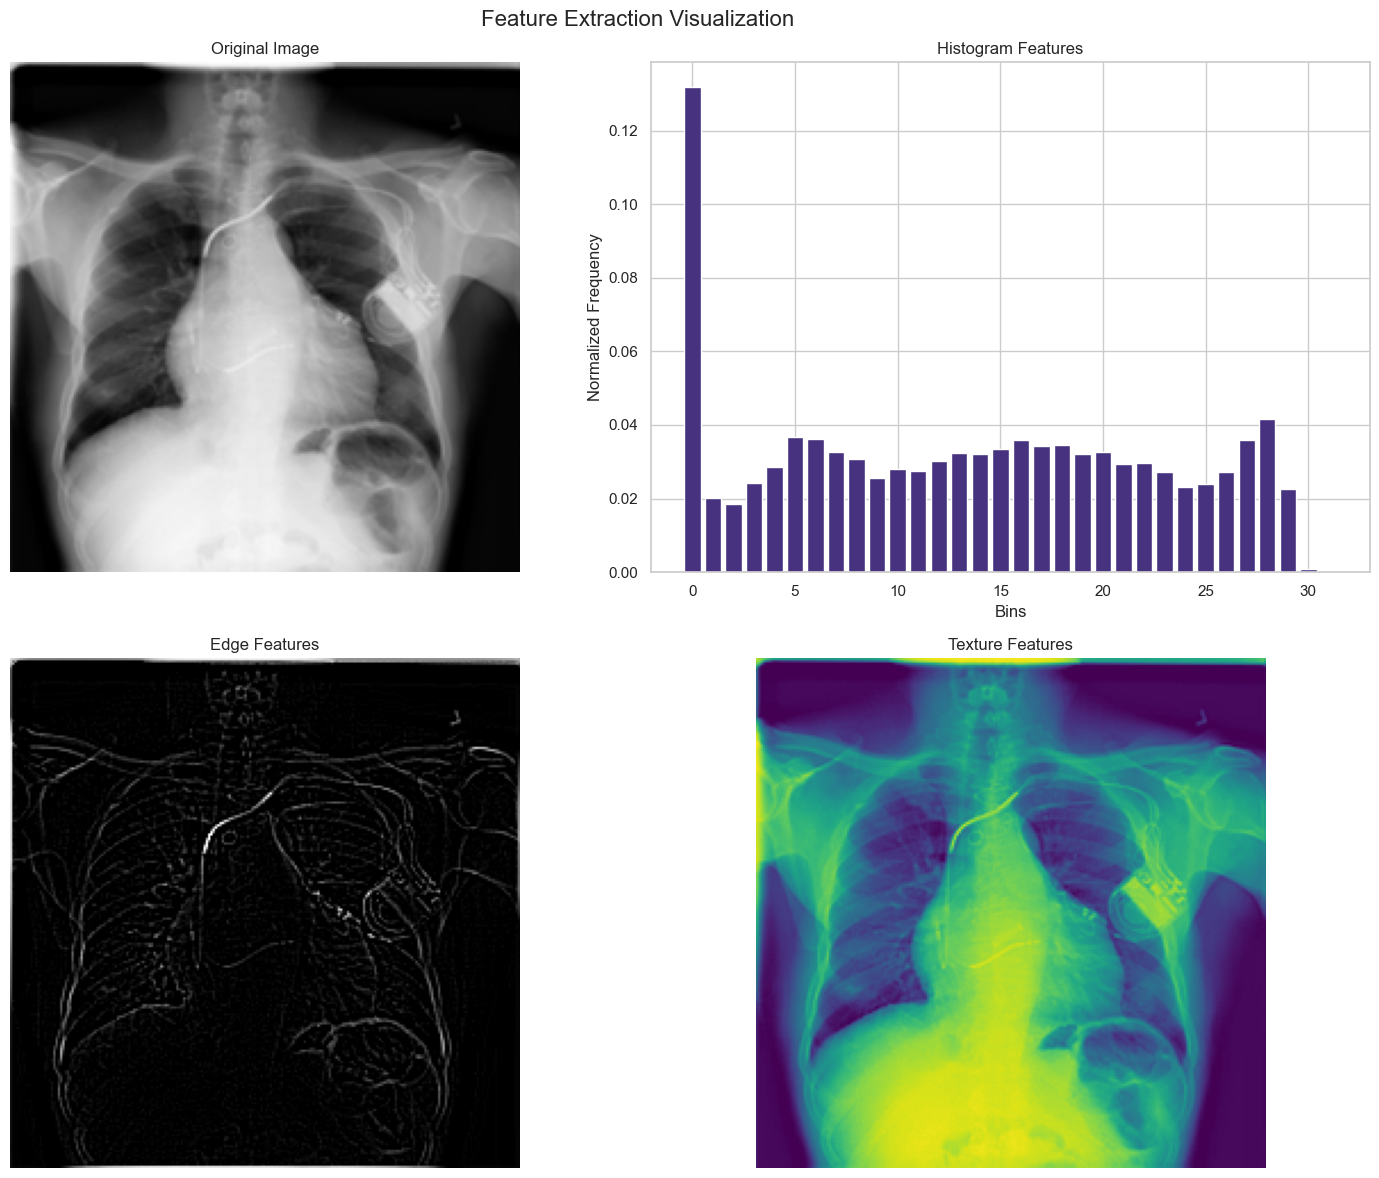


Visualizing features for: ..\pneumonia_dataset\Pneumonia\images\Viral Pneumonia-1256.png
Feature visualization saved to output/feature_visualization/pneumonia_Viral Pneumonia-1256.png.png
Feature visualization saved to output/feature_visualization/pneumonia_Viral Pneumonia-1256.png.png


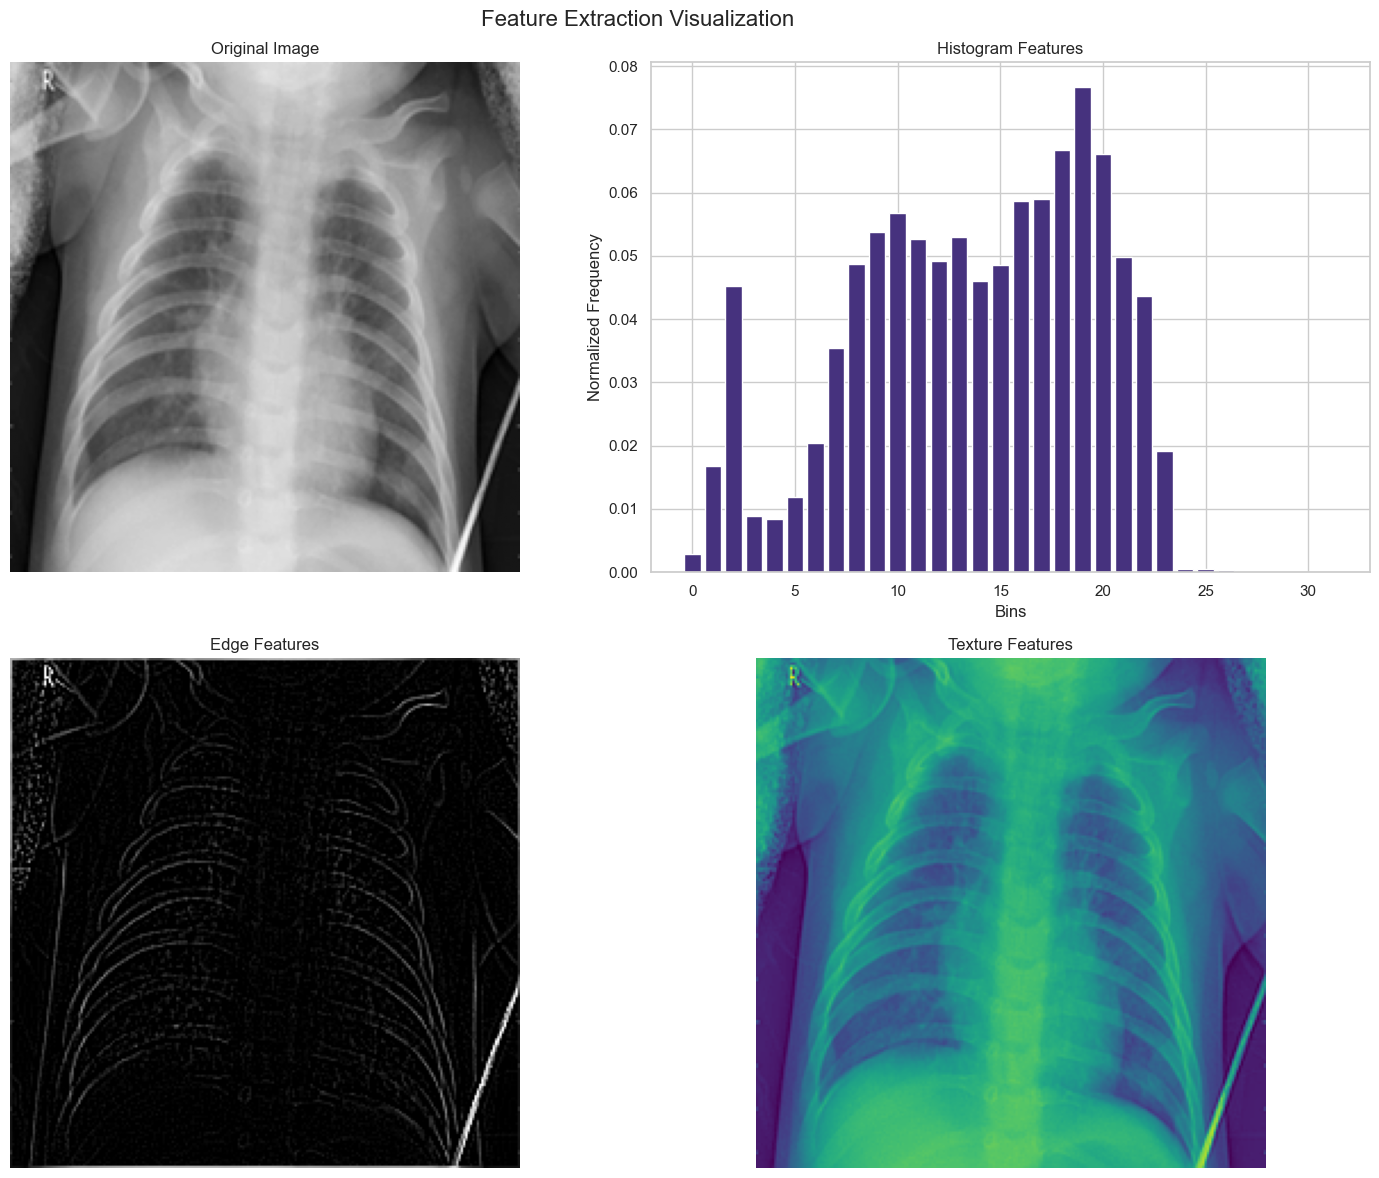

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
from pathlib import Path
from tqdm.notebook import tqdm
import random

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

os.makedirs('output/feature_visualization', exist_ok=True)

class FeatureExtractor:
    @staticmethod
    def extract_histogram(image, bins=32):
        """Extract color histogram features using PIL."""
        hist = np.histogram(np.array(image).flatten(), bins=bins, range=(0, 256))[0]
        return hist / hist.sum()  # Normalize
    
    @staticmethod
    def extract_edges(image, threshold1=100, threshold2=200):
        """Extract edge features using PIL's edge detection."""
        edges = image.filter(ImageFilter.FIND_EDGES)
        return np.array(edges).flatten() / 255.0
    
    @staticmethod
    def extract_texture(image, radius=1):
        """Extract texture features using PIL's edge enhancement."""
        enhancer = ImageEnhance.Sharpness(image)
        enhanced = enhancer.enhance(2.0) 
        return np.array(enhanced).flatten() / 255.0 
    
    @staticmethod
    def extract_all_features(image_path, target_size=(224, 224)):
        """Extract all features from an image using only PIL."""
        try:
            image = Image.open(image_path).convert('L')  
            image = image.resize(target_size)
            
            
            hist = FeatureExtractor.extract_histogram(image)
            edges = FeatureExtractor.extract_edges(image)
            texture = FeatureExtractor.extract_texture(image)
            
            features = np.hstack([
                hist,
                edges[:1000],  
                texture[:1000],  
                np.array(image).flatten() / 255.0 
            ])
            
            return features
            
        except Exception as e:
            print(f"Error extracting features from {image_path}: {e}")
            return None
    
    @staticmethod
    def visualize_features(image_path, save_path=None):
        """Visualize the extracted features for an image."""
        try:
            
            image = Image.open(image_path).convert('L')
            image = image.resize((224, 224))
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Feature Extraction Visualization', fontsize=16)
            
            
            axes[0, 0].imshow(image, cmap='gray')
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')
            
            
            hist = FeatureExtractor.extract_histogram(image)
            axes[0, 1].bar(range(len(hist)), hist)
            axes[0, 1].set_title('Histogram Features')
            axes[0, 1].set_xlabel('Bins')
            axes[0, 1].set_ylabel('Normalized Frequency')
            
            
            edges = FeatureExtractor.extract_edges(image)
            edges_2d = edges.reshape(224, 224)  
            axes[1, 0].imshow(edges_2d, cmap='gray')
            axes[1, 0].set_title('Edge Features')
            axes[1, 0].axis('off')
            
            
            texture = FeatureExtractor.extract_texture(image)
            texture_2d = texture.reshape(224, 224)  
            axes[1, 1].imshow(texture_2d, cmap='viridis')
            axes[1, 1].set_title('Texture Features')
            axes[1, 1].axis('off')
            
            plt.tight_layout()
            
            
            if save_path:
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                plt.savefig(save_path, bbox_inches='tight')
                print(f"Feature visualization saved to {save_path}")
                
            plt.show()
            return fig
            
        except Exception as e:
            print(f"Error visualizing features: {e}")
            return None

def extract_features_for_dataset(df, sample_size=None):
    """Extract features for all images in the dataset."""
    if sample_size is not None:
        df = df.sample(min(sample_size, len(df)), random_state=RANDOM_STATE)
    
    print(f"Extracting features for {len(df)} images...")
    
    features = []
    valid_indices = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_features = FeatureExtractor.extract_all_features(row['image_path'])
        if img_features is not None:
            features.append(img_features)
            valid_indices.append(idx)
    
    
    X = np.array(features)
    y = df.loc[valid_indices, 'label'].values
    
    print(f"\nFeature extraction complete.")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y, valid_indices

def visualize_sample_features(df, class_name='NORMAL', n_samples=1):
    """Visualize features for sample images."""
    samples = df[df['label'] == class_name].sample(n_samples, random_state=RANDOM_STATE)
    
    for _, row in samples.iterrows():
        print(f"\nVisualizing features for: {row['image_path']}")
        save_path = f"output/feature_visualization/{class_name.lower()}_{Path(row['image_path']).name}.png"
        FeatureExtractor.visualize_features(row['image_path'], save_path=save_path)

# Example usage:
# 1. Extract features for the dataset
X, y, valid_indices = extract_features_for_dataset(df, sample_size=100)

# 2. Visualize features for sample images
visualize_sample_features(df, class_name='NORMAL', n_samples=1)
visualize_sample_features(df, class_name='PNEUMONIA', n_samples=1)

### 8. Data Training

In [19]:
print("Loading data...")
data_loader = PneumoniaDataLoader('../pneumonia_dataset')
df = data_loader.get_dataframe()

print("\nDataset info:")
print(f"Total samples: {len(df)}")
print("Class distribution:")
print(df['label'].value_counts())


print("\nSample data:")
display(df.head())


print("\nExtracting features...")
X = []
valid_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    features = FeatureExtractor.extract_all_features(row['image_path'])
    if features is not None:
        X.append(features)
        valid_indices.append(idx)

if not X:
    print("Error: No features were extracted. Please check your images and feature extraction.")
else:
    X = np.array(X)
    y = df.loc[valid_indices, 'label'].values
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    print("\nProceed with model training...")

Loading data...

Processing NORMAL images from: ..\pneumonia_dataset\Normal\images
Found 4065 NORMAL images

Processing PNEUMONIA images from: ..\pneumonia_dataset\Pneumonia\images
Found 4065 NORMAL images

Processing PNEUMONIA images from: ..\pneumonia_dataset\Pneumonia\images
Found 1345 PNEUMONIA images

Loaded 5410 images
Class distribution:
NORMAL       4065
PNEUMONIA    1345
Name: count, dtype: int64

Dataset info:
Total samples: 5410
Class distribution:
label
NORMAL       4065
PNEUMONIA    1345
Name: count, dtype: int64

Sample data:
Found 1345 PNEUMONIA images

Loaded 5410 images
Class distribution:
NORMAL       4065
PNEUMONIA    1345
Name: count, dtype: int64

Dataset info:
Total samples: 5410
Class distribution:
label
NORMAL       4065
PNEUMONIA    1345
Name: count, dtype: int64

Sample data:


,image_path,label,width,height,mode,aspect_ratio,class
0,..\pneumonia_dataset\Normal\images\Normal-1.png,NORMAL,299,299,L,1.0,NORMAL
1,..\pneumonia_dataset\Normal\images\Normal-10.png,NORMAL,299,299,L,1.0,NORMAL
2,..\pneumonia_dataset\Normal\images\Normal-100.png,NORMAL,299,299,L,1.0,NORMAL
3,..\pneumonia_dataset\Normal\images\Normal-1000...,NORMAL,299,299,L,1.0,NORMAL
4,..\pneumonia_dataset\Normal\images\Normal-1001...,NORMAL,299,299,L,1.0,NORMAL



Extracting features...


  0%|          | 0/5410 [00:00<?, ?it/s]


Feature matrix shape: (5410, 52208)
Labels shape: (5410,)

Training set: 4328 samples
Test set: 1082 samples

Proceed with model training...

Training set: 4328 samples
Test set: 1082 samples

Proceed with model training...


## 8. Model Development
We'll train a Random Forest classifier with hyperparameter tuning.


PNEUMONIA CLASSIFIER INITIALIZED

Model Configuration:
  - Algorithm: Random Forest Classifier
  - Number of Estimators: 100
  - Max Depth: 10
  - Min Samples Split: 5
  - Min Samples Leaf: 2
  - Class Weight: balanced
  - Random State: 42

Model Status:
  - Trained: False
  - Model Path: output\models\pneumonia_rf_model.pkl

Model Directories Created:
  - Models: output/models/
  - Confusion Matrices: output/confusion_matrices/
  - ROC Curves: output/roc_curves/
  - Learning Curves: output/learning_curves/


Starting training with 4328 samples...
Starting training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished



Training Complete! Time: 0.60 minutes
Model saved to output\models\pneumonia_rf_model.pkl

Starting evaluation...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished



Evaluation Results:
Accuracy: 0.9575
Precision: 0.9584
Recall: 0.9575
F1: 0.9578
Roc_auc: 0.9915

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9788    0.9643    0.9715       813
   PNEUMONIA     0.8968    0.9368    0.9164       269

    accuracy                         0.9575      1082
   macro avg     0.9378    0.9506    0.9439      1082
weighted avg     0.9584    0.9575    0.9578      1082

Confusion matrix saved to output/confusion_matrices/confusion_matrix_pneumonia_rf.png


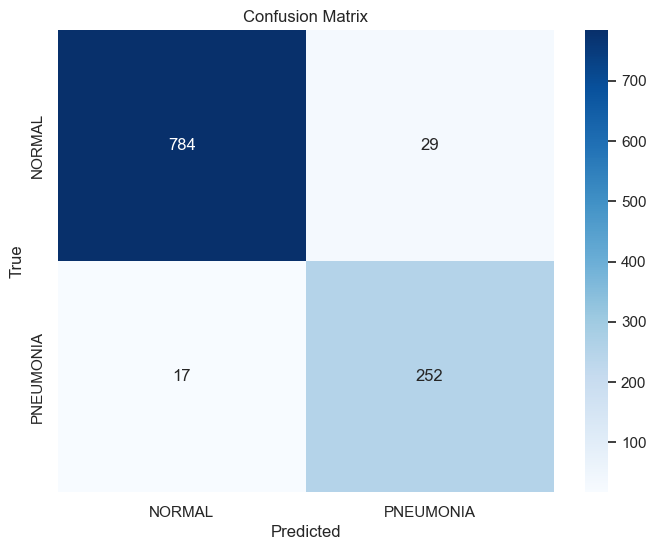

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


ROC curve saved to output/roc_curves/roc_curve_pneumonia_rf.png


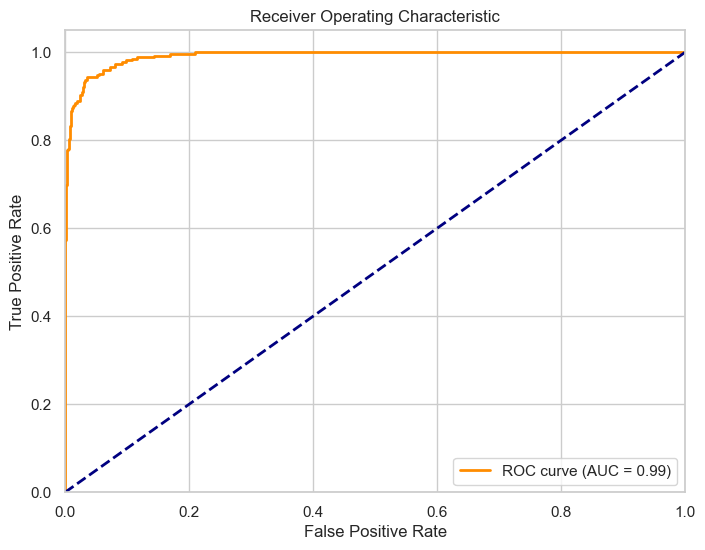

Learning curve saved to output/learning_curves/learning_curve_pneumonia_rf.png


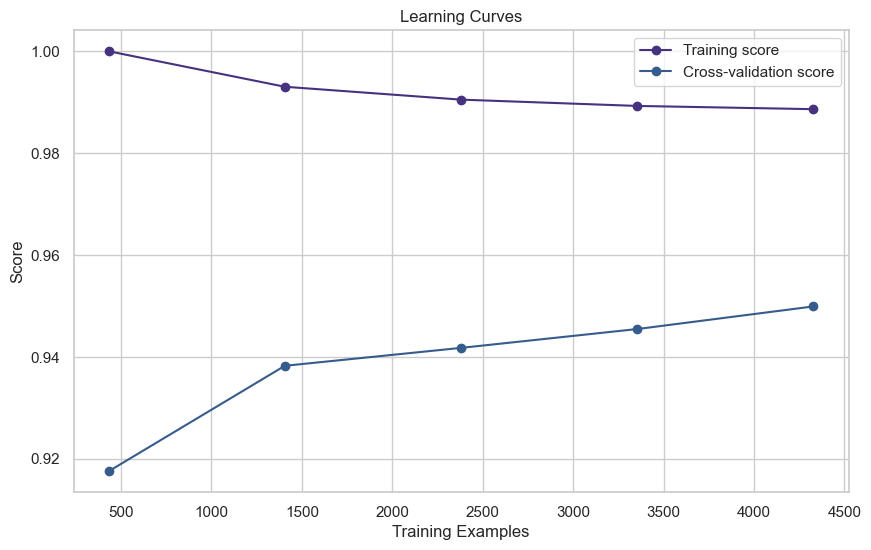

Feature importance plot saved to output/feature_importance_pneumonia_rf.png


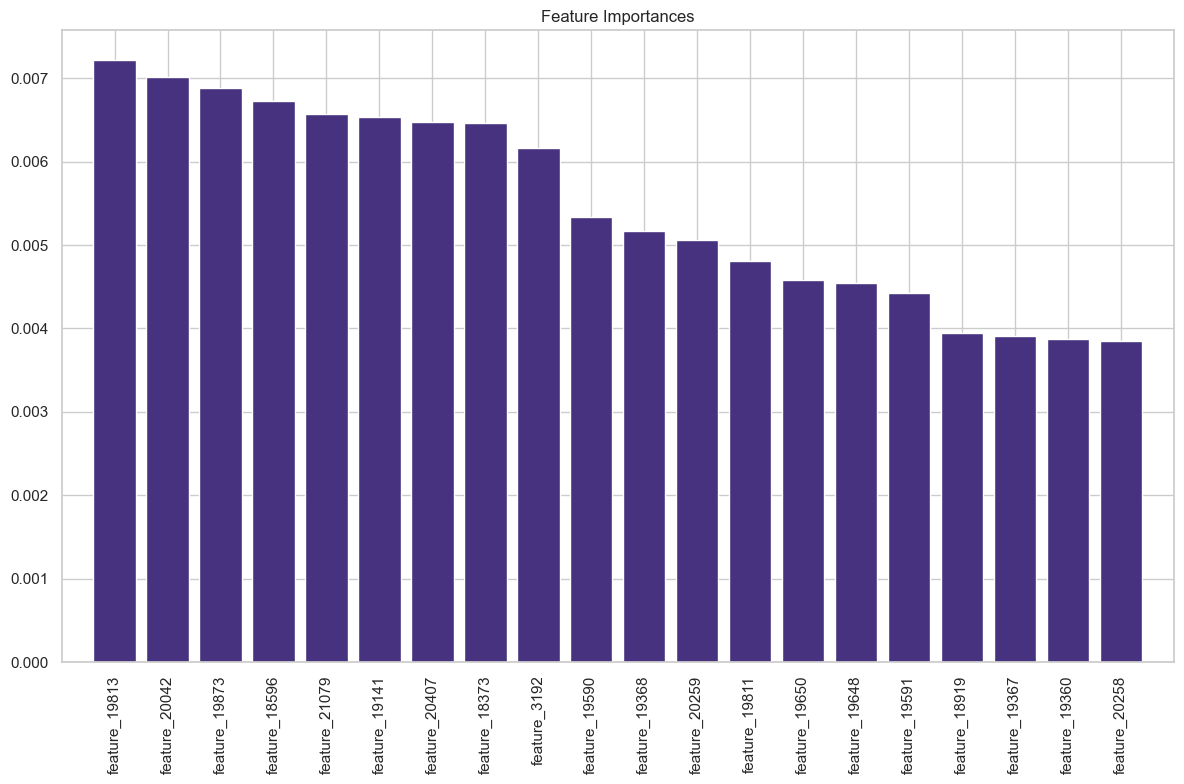

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Precision-Recall curve saved to output/roc_curves/precision_recall_curve_pneumonia_rf.png


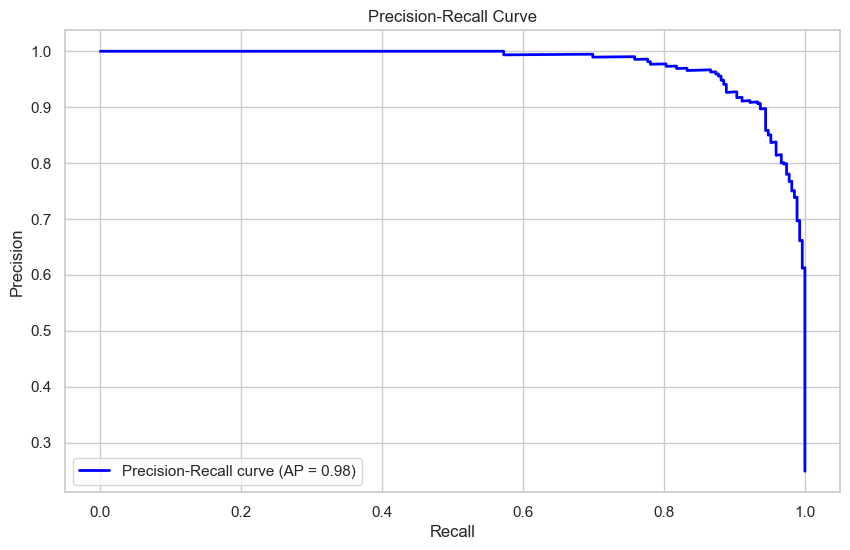

Model saved to output\models\pneumonia_rf_model.pkl


In [43]:
classifier = PneumoniaClassifier()
classifier.train(X_train, y_train)

evaluation_metrics = classifier.evaluate(X_test, y_test, save_path='pneumonia_rf')

classifier.plot_learning_curve(
    np.vstack((X_train, X_test)), 
    np.concatenate((y_train, y_test)),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    save_path='pneumonia_rf'
)

classifier.plot_feature_importance(save_path='pneumonia_rf')

y_pred = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_test_encoded = classifier.label_encoder.transform(y_test)

precision, recall, _ = precision_recall_curve(y_test_encoded, y_proba[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {average_precision_score(y_test_encoded, y_proba[:, 1]):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

save_file = 'output/roc_curves/precision_recall_curve_pneumonia_rf.png'
plt.savefig(save_file, bbox_inches='tight')
print(f"Precision-Recall curve saved to {save_file}")

plt.show()

classifier.save_model()